In [ ]:
# 경고(worning) 비표시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 제4장 고객의 행동을 예측하는 테크닉 10

- 데이터 설명

  - use_log.csv : 센터의 이용 이력 데이터 (2018년 4월 ~ 2019년 3월)

    use_log는 어떤 고객이 언제 센터를 이용했는지 알 수 있는 데이터

  - customer_join.csv : 3장에서 작성한 이용 이력을 포함한 고객 데이터

### 테크닉 31 : 데이터를 읽어들이고 확인하자

데이터를 읽고 결측치 파악

In [ ]:
import pandas as pd
uselog = pd.read_csv('/content/gdrive/MyDrive/pyda100-master/4장/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [ ]:
customer = pd.read_csv('/content/gdrive/MyDrive/pyda100-master/4장/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### 테크닉 32 : 클러스터링으로 회원을 그룹화하자

고객의 이용 이력을 이용해 그룹화를 진행

미리 정해진 답이 없기 때문에 비지도학습 클러스터링을 이용

- 클러스터링에 이용하는 변수

  고개의 한 달 이용 이력 데이터인 mean, median, max, min, membership_period

In [ ]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


- K-means

  변수 간의 거리를 기반으로 그룹화를 진행

  그룹화하고자 하는 수를 미리 정해야함 (K = 4f로 지정)

- 표준화
  
  값의 범위를 조절해줌

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[2 0 3 1]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


### 테크닉 33 : 클러스터링 결과를 분석하자

- 열 이름을 변경 후 각 그룹의 데이터 수 집계

In [ ]:
customer_clustering.columns = ["월평균값","월중앙값", "월최댓값", "월최솟값","회원기간", "cluster"]
customer_clustering.groupby("cluster").count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,763,763,763,763,763
1,846,846,846,846,846
2,1249,1249,1249,1249,1249
3,1334,1334,1334,1334,1334


그룹 0 이 가장 많음

- 그룹의 특징을 파악하기 위해서 평균값 계산

In [ ]:
customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,3.054713,2.888598,4.756225,1.653997,9.263434
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,4.677494,4.671337,7.232986,2.153723,36.915933
3,5.524239,5.375187,8.745877,2.687406,14.843328


그룹 1는 회원 기간이 짧지만, 이용률이 높은 회원

그룹 0은 회원기간이 짧고 가장 이용률이 낮은 회원

그룹 2과 그룹 3은 나머지 그룹보다 회원기간은 긴 편임

그룹 2와  그룹 3중 그룹 2는 회원 기간은 길지만 이용률은 약간 낮음

### 테크닉 34 : 클러스터링 결과를 가시화하자

- PCA 주성분 분석 (차원 축소의 대표적인 방법)

  차원 축소란 비지도학습의 일종으로 정보를 되도록 잃지 않게 하면서 새로운 축을 만드는 것

  클러스터링에 사용한 변수는 5개이고, 5개의 변수들을 2차원으로 그리기 위해서 차원 축소를 진행



In [ ]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

In [ ]:
pca_df.head()

,0,1,cluster
0,-0.846470,2.203685,2
1,-0.734830,2.221651,2
2,-1.088340,2.183213,2
3,-1.187138,2.156726,2
4,-2.042860,2.045502,2


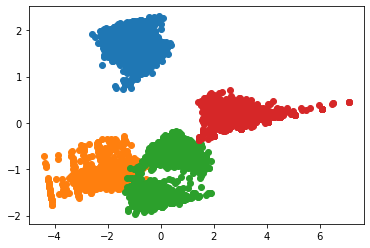

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

In [ ]:
tmp.head()

,0,1,cluster
1910,1.857782,0.631235,1
1978,2.327113,0.671056,1
1995,1.894566,0.637411,1
2017,1.833688,0.577782,1
2033,1.846809,0.579466,1


### 테크닉 35 : 클러스터링 결과를 바탕으로 탈퇴회원의 경향을 파악하자

클러스터링 결과를 바탕으로 그룹에 지속 회원과 탈퇴 회원이 얼마나 있었는지 파악

customer_clustering과 customer은 index로 연결되어 있기 때문에 concat함수로 결합이 가능

cluster과 is_deleted를 바탕으로 customer_id를 count



In [ ]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,1,763
1,1,0,827
2,1,1,19
3,2,0,1230
4,2,1,19
5,3,0,785
6,3,1,549


그룹 0은 탈퇴 회원만 있음

그룹 3은 골고루 포함

그룹 1,2는 지속 회원이 많음

- 정기적/비정기적 이용 여부

In [ ]:
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,497
1,0,1,266
2,1,0,52
3,1,1,794
4,2,0,2
5,2,1,1247
6,3,0,228
7,3,1,1106


지속 회원이 많았던 그룹 1,2에는 정기적으로 이용하는 회원이 많음

### 테크닉 36 : 다음달의 이용횟수 예측을 위해 테이터를 준비하자

고객의 과거 행동 데이터로부터 다음 달의 이용 횟수를 예측하는 경우에는 지도학습의 회귀분석을 이용

- uselog 데이터를 이용해 연월, 회원마다 집계

In [ ]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


과거 6개월을 이용해 다음달의 이용 횟수를 예측해야 하므로 과거 6개월의 데이터 저장

In [ ]:
# 연월 데이터 리스트 저장
year_months = list(uselog_months["연월"].unique())
# 6개월분의 이용 데이터를 취득해서 추가
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


- 결측치 제거
  - 대상 회원이 6개월 이상 재적 중인 회원이 됨

In [ ]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### 테크닉 37 : 특징이 되는 변수를 추가하자

회원 기간 : 시계열 변화를 볼 수 있기 때문

앞서 생성한 predict_data에  회원 기간 변수 (start_date)를 결합

In [ ]:
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


- 연월과 start_date의 차이를 이용해 회원 기간을 월 단위로 작성

In [ ]:
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### 테크닉 38 : 다음달 이용횟수를 예측하는 모델을 구축하자

2018년 4월 이후에 새로 가입한 회원만 이용해 모델을 작성

오래된 회원은 빼고 모델을 구축하는 이유는 오래된 회원은 가입 시기 데이터가 존재하지 않거나 이용 횟수가 안정적일 가능성이 있기 때문

In [ ]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
# 모델 초기화
model = linear_model.LinearRegression()
# 예측에 사용할 변수 (설명 변수)
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
# 예측하고 싶은 변수 (목적 변수)
y = predict_data["count_pred"]
# 학습용, 평가용 데이터로 분할 
# 분할 비율을 설정하지 않으면 기본값인 학습용 데이터 75%, 평가용 데이터 25%로 분할됨
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# 검증
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6085270638948134
0.600943295502949


### 테크닉 39 : 모델에 기여하는 변수를 확인하자

정확도가 높은 블랙박스 모델보다 정확도가 낮아도 설명이 가능한 모델이 사용되는 경우가 많음

In [ ]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.334589
1,count_1,0.211589
2,count_2,0.144230
3,count_3,0.180590
4,count_4,0.087545
5,count_5,0.089243
6,period,0.087085


count_0이 가장 크고 과거로 거슬러 올라갈수록 기여도가 작아지는 경향이 있음

즉, 이전 달의 이용 횟수가 다음 달의 이용 횟수에 영향을 미치고 있음


### 테크닉 40 : 다음달의 이용횟수를 예측하자

- 회원 2명의 이용 데이터를 작성

   두회원의 다음 달 방문 횟수를 예측

In [ ]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [ ]:
model.predict(x_pred)

array([3.89601239, 2.01281978])

첫번째 회원은 3.8회, 두번째 회원은 2회로 예측함

In [ ]:
uselog_months.to_csv("/content/gdrive/MyDrive/pyda100-master/4장/use_log_months.csv",index=False)